In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from google.colab import drive
import re
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Set device to GPU (cuda) if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [ ]:
# --- 1. DATA LOADING & PREPROCESSING ---

def load_data(file_path):
    """Loads text from a file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            corpus = f.read()
        return corpus
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
        print("Please make sure the file exists and the path is correct.\n")
        return None

def preprocess_and_tokenize(text, mode):
    """Applies preprocessing and tokenization based on the dataset type."""
    text = text.lower()
    if mode == 'text':
        text = re.sub(r'[^a-z0-9 \.]', '', text)
        tokens = text.split()
    elif mode == 'code':
        tokens = re.findall(r'\w+|[^\w\s]', text)
    return tokens

def build_vocab(tokens):
    """Builds vocabulary, word_to_idx, and idx_to_word maps."""
    word_counts = Counter(tokens)
    vocab = ['<PAD>', '<UNK>'] + sorted(word_counts, key=word_counts.get, reverse=True)

    word_to_idx = {word: i for i, word in enumerate(vocab)}
    idx_to_word = {i: word for i, word in enumerate(vocab)}

    return len(vocab), word_to_idx, idx_to_word

def create_sequences(tokens, word_to_idx, context_size):
    """Creates (X, y) sliding window sequences from tokens."""
    padding_token = '<PAD>'
    padded_tokens = [padding_token] * context_size + tokens

    X, y = [], []
    for i in range(len(padded_tokens) - context_size):
        context_tokens = padded_tokens[i : i + context_size]
        target_token = padded_tokens[i + context_size]

        # Convert tokens to indices
        context_indices = [word_to_idx.get(t, word_to_idx['<UNK>']) for t in context_tokens]
        target_index = word_to_idx.get(target_token, word_to_idx['<UNK>'])

        X.append(context_indices)
        y.append(target_index)

    return torch.LongTensor(X), torch.LongTensor(y)


class TextGenerationDataset(Dataset):
    """A simple PyTorch Dataset for (X, y) pairs."""
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_dataloaders(X, y, batch_size, val_split=0.1):
    """Splits data and creates train/validation DataLoaders."""
    dataset = TextGenerationDataset(X, y)

    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader

# --- 3. THE MLP MODEL ---

class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, context_size, n_layers=1, activation='relu'):
        super(MLPTextGenerator, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()

        layers = []
        input_dim = context_size * embed_dim 

        for _ in range(n_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(self.activation)
            layers.append(nn.Dropout(0.4)) 
            input_dim = hidden_dim 

        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embeds = self.embedding(x)

        flattened = embeds.view(x.shape[0], -1)

        hidden_out = self.hidden_layers(flattened)
        logits = self.output_layer(hidden_out)

        return logits

# --- 4. TRAINING & EVALUATION FUNCTIONS ---

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    """The main training and validation loop."""
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(1, epochs + 1):
        # --- Training ---
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)

        for contexts, targets in train_pbar:
            contexts, targets = contexts.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(contexts)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for contexts, targets in val_loader:
                contexts, targets = contexts.to(device), targets.to(device)

                outputs = model(contexts)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val Acc: {epoch_val_acc:.2f}%")

    return model, (train_losses, val_losses, val_accuracies)

# --- 5. REPORTING FUNCTIONS ---

def plot_loss(train_losses, val_losses, title):
    """Plots training and validation loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_text(model, word_to_idx, idx_to_word, context_size, seed_text, n_words, mode, device):
    """Generates text from a seed prompt."""
    model.eval()

    tokens = preprocess_and_tokenize(seed_text, mode)
    generated_text = tokens.copy()

    with torch.no_grad():
        for _ in range(n_words):
            context_tokens = generated_text[-context_size:]

            context_indices = [word_to_idx.get(t, word_to_idx['<UNK>']) for t in context_tokens]

            if len(context_indices) < context_size:
                padding_size = context_size - len(context_indices)
                context_indices = [word_to_idx['<PAD>']] * padding_size + context_indices

            context_tensor = torch.LongTensor(context_indices).unsqueeze(0).to(device)

            outputs = model(context_tensor)

            probabilities = torch.softmax(outputs, dim=1)
            predicted_idx = torch.multinomial(probabilities, 1).item()

            # Convert index to word and append
            predicted_word = idx_to_word[predicted_idx]

            # Stop if we generate a <PAD> token
            if predicted_word == '<PAD>':
                break

            generated_text.append(predicted_word)

    return ' '.join(generated_text)


========================= STARTING RUN: Text (adv.txt) =========================
Preprocessing and tokenizing...
Building vocabulary...
Creating (X, y) sequences...
Vocabulary Size: 16823
Total Sequences: 98014

Starting training for 30 epochs...


Epoch 1/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 7.1650 | Val Loss: 7.0089 | Val Acc: 6.52%


Epoch 2/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 6.7909 | Val Loss: 7.0159 | Val Acc: 7.93%


Epoch 3/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 6.5341 | Val Loss: 7.0590 | Val Acc: 8.83%


Epoch 4/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 6.3011 | Val Loss: 7.0041 | Val Acc: 9.15%


Epoch 5/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 6.0874 | Val Loss: 7.0872 | Val Acc: 9.16%


Epoch 6/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 5.8740 | Val Loss: 7.1148 | Val Acc: 9.17%


Epoch 7/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 5.6973 | Val Loss: 7.1849 | Val Acc: 9.72%


Epoch 8/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 5.5111 | Val Loss: 7.2529 | Val Acc: 9.73%


Epoch 9/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 9/30 | Train Loss: 5.3407 | Val Loss: 7.3719 | Val Acc: 9.65%


Epoch 10/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 5.1738 | Val Loss: 7.4969 | Val Acc: 9.69%


Epoch 11/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 5.0118 | Val Loss: 7.6452 | Val Acc: 9.66%


Epoch 12/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 4.8365 | Val Loss: 7.8025 | Val Acc: 9.62%


Epoch 13/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 4.6689 | Val Loss: 7.9800 | Val Acc: 9.22%


Epoch 14/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 4.5123 | Val Loss: 8.1897 | Val Acc: 9.27%


Epoch 15/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 4.3409 | Val Loss: 8.4113 | Val Acc: 9.18%


Epoch 16/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 4.1841 | Val Loss: 8.6273 | Val Acc: 8.49%


Epoch 17/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 4.0188 | Val Loss: 8.9357 | Val Acc: 8.18%


Epoch 18/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 3.8834 | Val Loss: 9.0724 | Val Acc: 7.94%


Epoch 19/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 3.7445 | Val Loss: 9.2405 | Val Acc: 7.58%


Epoch 20/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 3.6291 | Val Loss: 9.4842 | Val Acc: 7.59%


Epoch 21/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 3.5071 | Val Loss: 9.6643 | Val Acc: 7.57%


Epoch 22/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 3.3997 | Val Loss: 9.9282 | Val Acc: 7.11%


Epoch 23/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 3.3115 | Val Loss: 10.1161 | Val Acc: 7.11%


Epoch 24/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 3.2238 | Val Loss: 10.2317 | Val Acc: 7.19%


Epoch 25/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 3.1377 | Val Loss: 10.3580 | Val Acc: 6.86%


Epoch 26/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss: 3.0671 | Val Loss: 10.4885 | Val Acc: 6.79%


Epoch 27/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss: 3.0041 | Val Loss: 10.7011 | Val Acc: 6.85%


Epoch 28/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss: 2.9270 | Val Loss: 10.9086 | Val Acc: 6.52%


Epoch 29/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss: 2.8683 | Val Loss: 10.9708 | Val Acc: 6.75%


Epoch 30/30 [Train]:   0%|          | 0/345 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 2.8071 | Val Loss: 11.2320 | Val Acc: 6.91%

--- 📊 Final Report for Text (adv.txt) ---
Final Validation Loss: 11.2320
Final Validation Accuracy: 6.91%


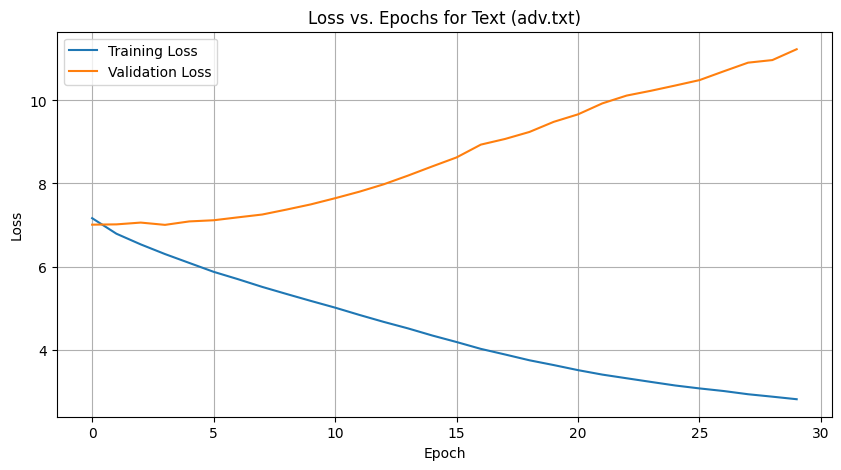


--- 💬 Example Predictions ---
Seed: 'sherlock holmes was a'
Generated: 'sherlock holmes was a cold keep hishands and all weapon. after what do you know the very well of doubt save much more out in the matter had some house might very nicely but'

---  commentary ---
This MLP model learns n-gram-like patterns (predicting a word based on the previous 5).
At 30 epochs, the model should move from generating random words to creating sequences that are
locally coherent (e.g., 'sherlock holmes said the' or 'import torch as np').
You may still see repetition or long-range nonsense, as the MLP has no memory
of words generated before the 5-word context window.

=========================== ENDING RUN: Text (adv.txt) ===========================



========================= STARTING RUN: Code (code.txt) =========================
Preprocessing and tokenizing...
Building vocabulary...
Creating (X, y) sequences...
Vocabulary Size: 32823
Total Sequences: 1317002

Starting training for 30 epochs...


Epoch 1/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 4.4641 | Val Loss: 4.0576 | Val Acc: 37.77%


Epoch 2/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 4.0440 | Val Loss: 3.8895 | Val Acc: 39.28%


Epoch 3/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 3.8906 | Val Loss: 3.8388 | Val Acc: 39.74%


Epoch 4/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 3.7988 | Val Loss: 3.8186 | Val Acc: 40.39%


Epoch 5/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 3.7412 | Val Loss: 3.7939 | Val Acc: 40.62%


Epoch 6/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 3.7102 | Val Loss: 3.7993 | Val Acc: 40.92%


Epoch 7/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 3.6888 | Val Loss: 3.7874 | Val Acc: 41.25%


Epoch 8/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 3.6717 | Val Loss: 3.7963 | Val Acc: 41.25%


Epoch 9/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 9/30 | Train Loss: 3.6622 | Val Loss: 3.8004 | Val Acc: 41.61%


Epoch 10/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 3.6546 | Val Loss: 3.8062 | Val Acc: 41.59%


Epoch 11/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 3.6510 | Val Loss: 3.7958 | Val Acc: 41.81%


Epoch 12/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 3.6424 | Val Loss: 3.7992 | Val Acc: 41.80%


Epoch 13/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 3.6431 | Val Loss: 3.8129 | Val Acc: 41.99%


Epoch 14/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 3.6385 | Val Loss: 3.8083 | Val Acc: 41.95%


Epoch 15/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 3.6388 | Val Loss: 3.8239 | Val Acc: 42.02%


Epoch 16/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 3.6390 | Val Loss: 3.8242 | Val Acc: 41.93%


Epoch 17/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 3.6385 | Val Loss: 3.8471 | Val Acc: 42.03%


Epoch 18/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 3.6412 | Val Loss: 3.8450 | Val Acc: 42.19%


Epoch 19/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 3.6447 | Val Loss: 3.8688 | Val Acc: 42.15%


Epoch 20/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 3.6485 | Val Loss: 3.8785 | Val Acc: 42.11%


Epoch 21/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 3.6463 | Val Loss: 3.8987 | Val Acc: 42.23%


Epoch 22/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 3.6506 | Val Loss: 3.9081 | Val Acc: 42.27%


Epoch 23/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 3.6553 | Val Loss: 3.9249 | Val Acc: 42.23%


Epoch 24/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 3.6559 | Val Loss: 3.9262 | Val Acc: 42.32%


Epoch 25/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 3.6605 | Val Loss: 3.9382 | Val Acc: 42.23%


Epoch 26/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss: 3.6623 | Val Loss: 3.9596 | Val Acc: 42.25%


Epoch 27/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss: 3.6626 | Val Loss: 3.9962 | Val Acc: 42.16%


Epoch 28/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss: 3.6690 | Val Loss: 3.9929 | Val Acc: 42.25%


Epoch 29/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss: 3.6709 | Val Loss: 4.0392 | Val Acc: 42.40%


Epoch 30/30 [Train]:   0%|          | 0/4631 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 3.6725 | Val Loss: 4.0296 | Val Acc: 42.24%

--- 📊 Final Report for Code (code.txt) ---
Final Validation Loss: 4.0296
Final Validation Accuracy: 42.24%


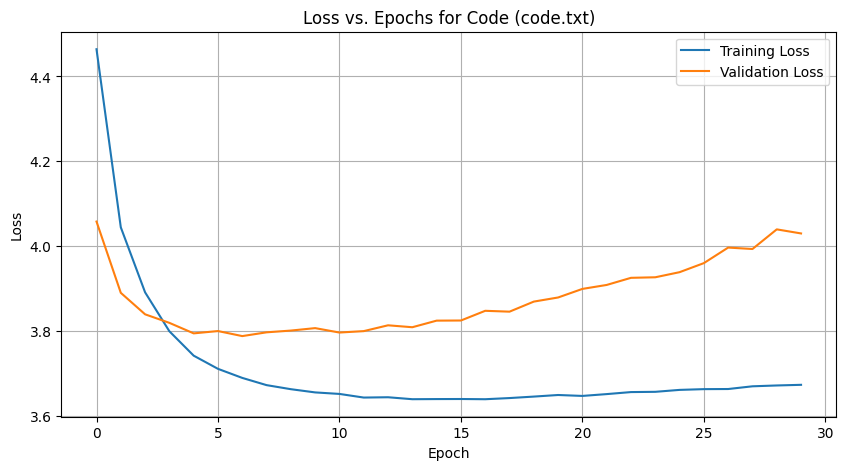


--- 💬 Example Predictions ---
Seed: 'import torch.nn as'
Generated: 'import torch . nn as restart the page . * * this case 0 is exiting cpu on ipi after if invocation of virtual allocates things down ) \ for : bpf_dw already its higher'

---  commentary ---
This MLP model learns n-gram-like patterns (predicting a word based on the previous 5).
At 30 epochs, the model should move from generating random words to creating sequences that are
locally coherent (e.g., 'sherlock holmes said the' or 'import torch as np').
You may still see repetition or long-range nonsense, as the MLP has no memory
of words generated before the 5-word context window.

=========================== ENDING RUN: Code (code.txt) ===========================


✅ All training complete. Models are stored in `trained_models` and vocabs in `vocabs`.


In [ ]:
# --- 0. Configuration ---
path_to_adv_txt = '/content/drive/My Drive/Colab Notebooks/adv.txt'
path_to_code_txt = '/content/drive/My Drive/Colab Notebooks/code.txt' 

# Define the model hyperparameters
CONTEXT_SIZE = 5      
EMBEDDING_DIM = 64    
HIDDEN_DIM = 1024     
N_LAYERS = 2          
ACTIVATION = 'relu'   
LEARNING_RATE = 0.001
BATCH_SIZE = 256      
EPOCHS = 30           

configs = [
    {
        'id': 'text',
        'name': 'Text (adv.txt)',
        'path': path_to_adv_txt,
        'mode': 'text',
        'seed_text': 'sherlock holmes was a'
    },
    {
        'id': 'code', 
        'name': 'Code (code.txt)',
        'path': path_to_code_txt,
        'mode': 'code',
        'seed_text': 'import torch.nn as'
    }
]

trained_models = {}
vocabs = {}

for config in configs:
    print(f"\n{'='*25} STARTING RUN: {config['name']} {'='*25}")

    # 1. Load and Preprocess Data
    corpus = load_data(config['path'])
    if corpus is None:
        continue 

    print("Preprocessing and tokenizing...")
    tokens = preprocess_and_tokenize(corpus, config['mode'])

    print("Building vocabulary...")
    vocab_size, word_to_idx, idx_to_word = build_vocab(tokens)

    vocabs[config['id']] = {'word_to_idx': word_to_idx, 'idx_to_word': idx_to_word}

    print("Creating (X, y) sequences...")
    X, y = create_sequences(tokens, word_to_idx, CONTEXT_SIZE)

    print(f"Vocabulary Size: {vocab_size}")
    print(f"Total Sequences: {len(X)}")

    train_loader, val_loader = get_dataloaders(X, y, BATCH_SIZE)

    model = MLPTextGenerator(
        vocab_size=vocab_size,
        embed_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        context_size=CONTEXT_SIZE,
        n_layers=N_LAYERS,
        activation=ACTIVATION
    ).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<PAD>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 4. Train Model
    print(f"\nStarting training for {EPOCHS} epochs...")
    trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS)

    trained_models[config['id']] = trained_model

    train_losses, val_losses, val_accuracies = history

    print(f"\n--- 📊 Final Report for {config['name']} ---")

    final_val_loss = val_losses[-1]
    final_val_acc = val_accuracies[-1]
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")

    plot_loss(train_losses, val_losses, title=f"Loss vs. Epochs for {config['name']}")

    # Example Predictions
    print("\n--- 💬 Example Predictions ---")
    generated = generate_text(
        trained_model, 
        word_to_idx,
        idx_to_word,
        CONTEXT_SIZE,
        config['seed_text'],
        n_words=30,
        mode=config['mode'],
        device=device
    )
    print(f"Seed: '{config['seed_text']}'")
    print(f"Generated: '{generated}'")

    # Commentary
    print("\n---  commentary ---")
    print("This MLP model learns n-gram-like patterns (predicting a word based on the previous 5).")
    print(f"At {EPOCHS} epochs, the model should move from generating random words to creating sequences that are")
    print("locally coherent (e.g., 'sherlock holmes said the' or 'import torch as np').")
    print("You may still see repetition or long-range nonsense, as the MLP has no memory")
    print("of words generated before the 5-word context window.")

    print(f"\n{'='*27} ENDING RUN: {config['name']} {'='*27}\n\n")

print("✅ All training complete. Models are stored in `trained_models` and vocabs in `vocabs`.")

--- 1. Visualizing 'adv.txt' (Text) Embeddings ---


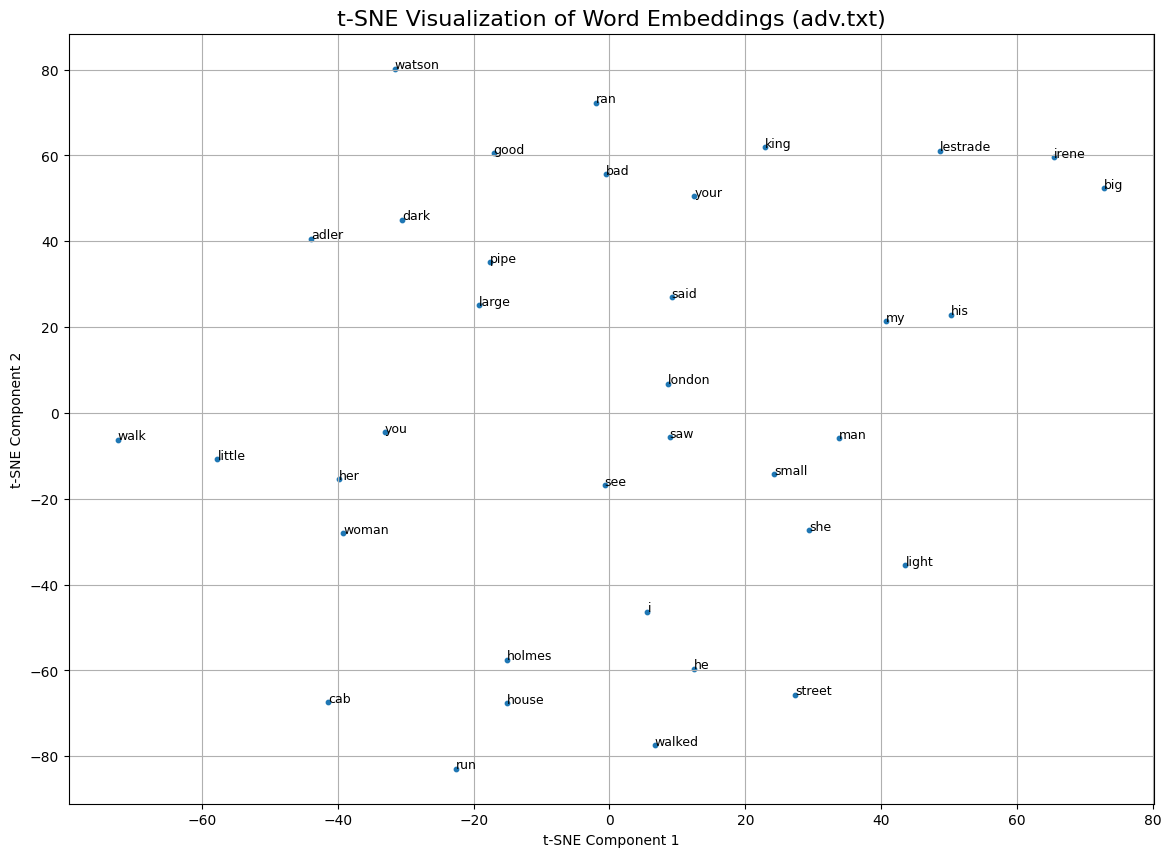


--- 2. Visualizing 'code.txt' (Code) Embeddings ---


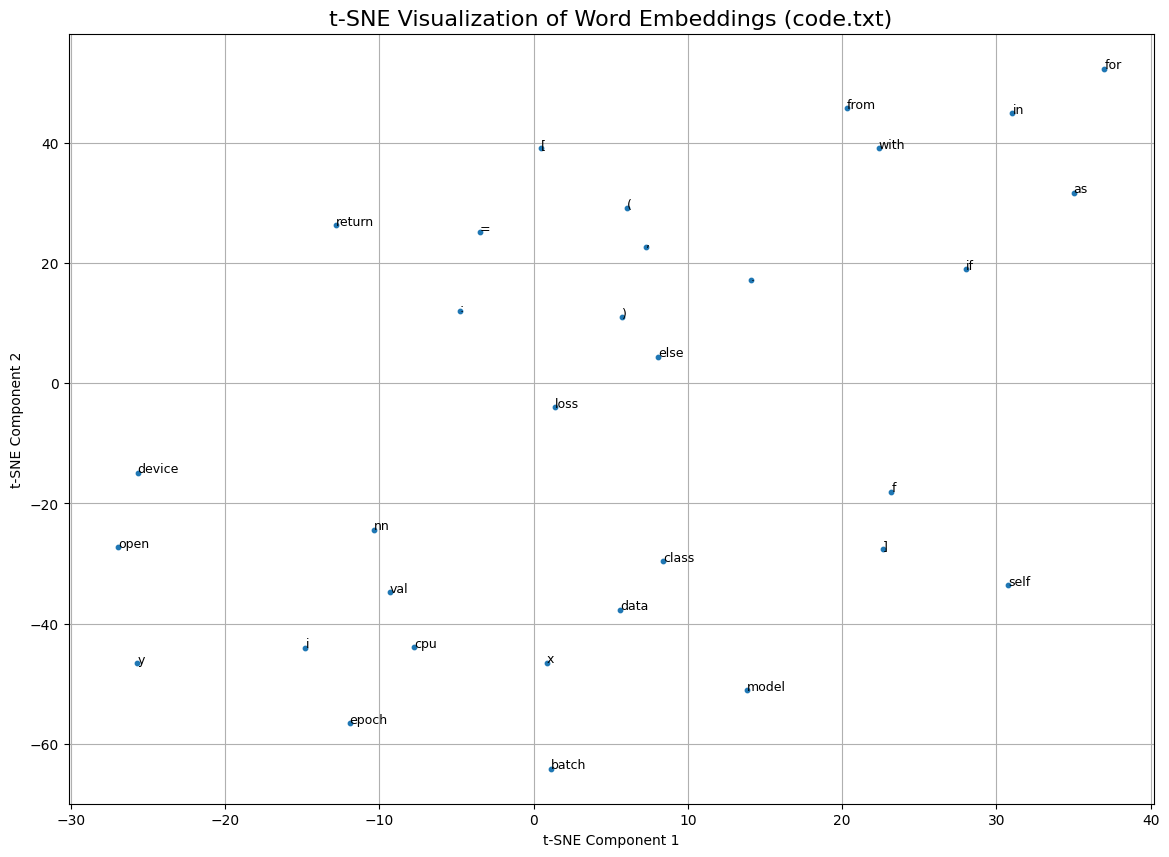

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings(model, word_to_idx, idx_to_word, word_list, title):
    """
    Extracts embeddings for a word list, runs t-SNE, and plots the result.
    """
    if model is None:
        print(f"Cannot visualize: Model for '{title}' is not trained.")
        return

    embeddings = model.embedding.weight.data.cpu().numpy()

    valid_words = []
    vectors = []
    for word in word_list:
        idx = word_to_idx.get(word, 1) 
        if idx != 1: 
            valid_words.append(word)
            vectors.append(embeddings[idx])

    if len(vectors) < 2:
        print(f"Not enough valid words found in vocabulary to plot for '{title}'.")
        return

    vectors = np.array(vectors)

    tsne_perplexity = min(5, len(vectors) - 1) 
    if tsne_perplexity <= 0:
        print(f"Cannot run t-SNE for '{title}': Need at least 2 valid words.")
        return

    tsne = TSNE(n_components=2,
                perplexity=tsne_perplexity,
                random_state=42,
                init='pca',
                learning_rate='auto')

    vectors_2d = tsne.fit_transform(vectors)

    # 4. Plot the results
    plt.figure(figsize=(14, 10))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=10) 

    for i, word in enumerate(valid_words):
        plt.annotate(word,
                     (vectors_2d[i, 0], vectors_2d[i, 1]),
                     fontsize=9)

    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()


text_word_list = [
    'small', 'little', 'large', 'big',
    'good', 'bad', 'dark', 'light', 'man', 'woman',
    'holmes', 'watson', 'irene', 'adler', 'lestrade',
    'he', 'she', 'his', 'her', 'i', 'you', 'my', 'your',
    'run', 'ran', 'walk', 'walked', 'see', 'saw', 'said',
    'house', 'street', 'london', 'pipe', 'cab', 'king'
]

code_word_list = [
    'torch', 'nn', 'optim', 'import', 'from', 'as',
    'def', 'class', 'return', 'if', 'else', 'for', 'in', 'with', 'open',
    '.', ',', '(', ')', '[', ']', '=', ':',
    'model', 'train', 'val', 'loss', 'data', 'batch', 'epoch', 'device', 'cpu', 'cuda',
    'x', 'y', 'i', 'f', 'self'
]



try:
    print("--- 1. Visualizing 'adv.txt' (Text) Embeddings ---")
    visualize_embeddings(
        trained_models['text'],
        vocabs['text']['word_to_idx'],
        vocabs['text']['idx_to_word'],
        text_word_list,
        "t-SNE Visualization of Word Embeddings (adv.txt)"
    )
except KeyError:
    print("Error: 'text' model not found. Please run Cell 3 to train the models.")
except NameError:
    print("Error: `trained_models` not defined. Please run Cell 3 to train the models.")

try:
    print("\n--- 2. Visualizing 'code.txt' (Code) Embeddings ---")
    visualize_embeddings(
        trained_models['code'],
        vocabs['code']['word_to_idx'],
        vocabs['code']['idx_to_word'],
        code_word_list,
        "t-SNE Visualization of Word Embeddings (code.txt)"
    )
except KeyError:
    print("Error: 'code' model not found. Please run Cell 3 to train the models.")
except NameError:
    print("Error: `trained_models` not defined. Please run Cell 3 to train the models.")

Dataset size- the code dataset was nearly 13 times large than the text dataset

Vocabulary size - the code dataset has nearly twice the vocab size of text dataset as the code tokenizer treats every special character as a different token

The predictability of code is higher than text as in case of code the model has to learn the sytax which are much simpler than having to learn the semantics of text.

To summarize it is easier for the model to learn the structured language of code than text due to fixed set of rules. Therefore a small context size of 5 also performs well on code dataset than text dataset where a context window of 5 is barerly enough to capture any context and meaning for the model to learn.